In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from data import df
from pytorch import collate_fn, TweetDataset

In [3]:
def df_to_seq_tgt(df: pd.DataFrame):
    grouped = df.groupby(['date', 'ID_QI'])
    sequences = []
    targets = []
    for (date, ID_QI), group in grouped:
        features = group[['f1', 'f2', 'm1', 'm2']].values
        assert group['c2cdr'].nunique() == 1
        target = group['c2cdr'].iloc[0]  # Single target for the group
        sequences.append(features)
        targets.append(target)
    sequences = [torch.tensor(seq, dtype=torch.float32) for seq in sequences]
    targets = torch.tensor(targets, dtype=torch.float32)
    return sequences, targets

N_FEATS = 2

# premier test

In [3]:
torch.manual_seed(0)
seq_1 = torch.randn(5, 128)  # 5 tweets, 128-dim embeddings
seq_2 = torch.randn(3, 128)  # 3 tweets, 128-dim embeddings
seq_3 = torch.randn(7, 128)  # 7 tweets, 128-dim embeddings

# Pad sequences so they are the same length
padded_seqs = pad_sequence([seq_1, seq_2, seq_3], batch_first=True) 
# shape = b_size, max_n_tweets, 128
# avec b_size=3 et max_n_tweets=7

# Create masks to identify the real data points
lengths = [seq_1.size(0), seq_2.size(0), seq_3.size(0)]
mask = torch.arange(padded_seqs.size(1)).unsqueeze(0) < torch.tensor(lengths).unsqueeze(1)

# Example of applying a weighted average (mask-aware)
weights = torch.randn_like(padded_seqs)
weighted_sum = torch.sum(weights * padded_seqs * mask.unsqueeze(2), dim=1)
average = weighted_sum / mask.sum(dim=1, keepdim=True)

In [78]:
average[0] - (torch.sum((weights[0, :5] * seq_1), dim=0) / 5)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.])

# vrai donnees

In [5]:
sequences, targets = df_to_seq_tgt(df)

In [6]:
sequences

[tensor([[0.1000, 1.1000, 2.1000, 3.3000],
         [0.2000, 1.2000, 2.2000, 3.4000],
         [0.5000, 3.4000, 3.3000, 3.2000]]),
 tensor([[0.3000, 1.3000, 2.3000, 3.5000],
         [0.4000, 3.3000, 2.4000, 3.1000]]),
 tensor([[0.3000, 1.4000, 3.5000, 3.4000],
         [3.3000, 1.5000, 2.5000, 3.5000]]),
 tensor([[0.2000, 3.5000, 3.4000, 3.3000]]),
 tensor([[3.5000, 0.3000, 0.3000, 0.1000]]),
 tensor([[3.4000, 0.2000, 0.2000, 0.2000]])]

In [7]:
targets[:3]

tensor([0.5600, 0.5700, 0.6600])

In [22]:
padded_sequences = pad_sequence(sequences, batch_first=True)
lengths = torch.tensor([len(seq) for seq in sequences])

In [23]:
padded_sequences

tensor([[[0.1000, 1.1000, 2.1000, 3.3000],
         [0.2000, 1.2000, 2.2000, 3.4000],
         [0.5000, 3.4000, 3.3000, 3.2000]],

        [[0.3000, 1.3000, 2.3000, 3.5000],
         [0.4000, 3.3000, 2.4000, 3.1000],
         [0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.3000, 1.4000, 3.5000, 3.4000],
         [3.3000, 1.5000, 2.5000, 3.5000],
         [0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.2000, 3.5000, 3.4000, 3.3000],
         [0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000]],

        [[3.5000, 0.3000, 0.3000, 0.1000],
         [0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000]],

        [[3.4000, 0.2000, 0.2000, 0.2000],
         [0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000]]])

In [24]:
packed_x = pack_padded_sequence(padded_sequences, lengths.cpu(), batch_first=True, enforce_sorted=False)
packed_x

PackedSequence(data=tensor([[0.1000, 1.1000, 2.1000, 3.3000],
        [0.3000, 1.3000, 2.3000, 3.5000],
        [0.3000, 1.4000, 3.5000, 3.4000],
        [0.2000, 3.5000, 3.4000, 3.3000],
        [3.5000, 0.3000, 0.3000, 0.1000],
        [3.4000, 0.2000, 0.2000, 0.2000],
        [0.2000, 1.2000, 2.2000, 3.4000],
        [0.4000, 3.3000, 2.4000, 3.1000],
        [3.3000, 1.5000, 2.5000, 3.5000],
        [0.5000, 3.4000, 3.3000, 3.2000]]), batch_sizes=tensor([6, 3, 1]), sorted_indices=tensor([0, 1, 2, 3, 4, 5]), unsorted_indices=tensor([0, 1, 2, 3, 4, 5]))

In [8]:
tweet_dataset = TweetDataset(sequences, targets)
data_loader = DataLoader(tweet_dataset, batch_size=4, shuffle=True, collate_fn=lambda x: collate_fn(x, N_FEATS))

In [21]:
class TweetAttentionMLP(nn.Module):
    def __init__(self, embedding_dim=2, meta_dim=2, mlp_dim=32):
        super(TweetAttentionMLP, self).__init__()
        self.intermediary_layer = nn.Linear(embedding_dim + meta_dim, embedding_dim + meta_dim)
        self.attention_layer = nn.Linear(embedding_dim + meta_dim, 1)
        self.mlp = nn.Sequential(
            nn.Linear(embedding_dim, mlp_dim),
            nn.ReLU(),
            nn.Linear(mlp_dim, 1)
        )

    def forward(self, embeddings, meta_features, lengths):
        """
        embeddings: tensor of shape (batch_size, L_max, embedding_dim) (padded)
        meta_features: tensor of shape (batch_size, L_max, meta_dim) (padded)
        lengths: tensor of shape (batch_size,) indicating the actual length of each sequence
        """
        batch_size, L_max, _ = embeddings.shape
        concat_features = torch.cat([embeddings, meta_features], dim=-1)  # Shape: (batch_size, L_max, embedding_dim + meta_dim)
        transformed_features = torch.tanh(self.intermediary_layer(concat_features))  # Shape: (batch_size, L_max, embedding_dim + meta_dim)
        w_l = torch.sigmoid(self.attention_layer(transformed_features)).squeeze(-1)  # Shape: (batch_size, L_max)
        mask = torch.arange(L_max).expand(batch_size, L_max) < lengths.unsqueeze(1)  # Shape: (batch_size, L_max)
        mask = mask.to(embeddings.device)
        w_l = w_l.masked_fill(~mask, -float('inf'))  # Mask out padded positions by setting large negative values
        alpha_l = F.softmax(w_l, dim=1)  # Shape: (batch_size, L_max)
        weighted_embedding = torch.sum(alpha_l.unsqueeze(-1) * embeddings, dim=1)  # Shape: (batch_size, embedding_dim)
        prediction = self.mlp(weighted_embedding).squeeze(-1)  # Shape: (batch_size,)
        return prediction
    

class TimeAttentionMLP(nn.Module):
    def __init__(self, embedding_dim=2, meta_dim=2, L=3, mlp_dim=32, freeze_theta=True, inf_value=float('-inf')):
        super(TimeAttentionMLP, self).__init__()
        self.intermediary_layer = nn.Linear(embedding_dim + meta_dim, embedding_dim + meta_dim)
        self.attention_layer = nn.Linear(embedding_dim + meta_dim, 1)
        self.theta = nn.Parameter(torch.ones(L))
        if freeze_theta:
            self.theta.requires_grad = False
        self.mlp = nn.Sequential(
            nn.Linear(embedding_dim, mlp_dim),
            nn.ReLU(),
            nn.Linear(mlp_dim, 1)
        )
        self.inf_value = inf_value

    def forward(self, embeddings, meta_features, lengths):
        """
        embeddings: tensor of shape (batch_size, L_max, embedding_dim) (padded)
        meta_features: tensor of shape (batch_size, L_max, meta_dim) (padded)
        lengths: tensor of shape (batch_size,) indicating the actual length of each sequence
        """
        batch_size, L_max, _ = embeddings.shape
        concat_features = torch.cat([embeddings, meta_features], dim=-1)  # Shape: (batch_size, L_max, embedding_dim + meta_dim)
        transformed_features = torch.tanh(self.intermediary_layer(concat_features))  # Shape: (batch_size, L_max, embedding_dim + meta_dim)
        o_t = torch.sigmoid(self.attention_layer(transformed_features)).squeeze(-1)  # Shape: (batch_size, L_max)
        mask = torch.arange(L_max).expand(batch_size, L_max) < lengths.unsqueeze(1)  # Shape: (batch_size, L_max)
        mask = mask.to(embeddings.device)
        o_t = o_t.masked_fill(~mask, self.inf_value)
        beta_t = F.softmax(o_t * self.theta[:L_max], dim=1)  # Shape: (batch_size, L_max)
        weighted_embedding = torch.sum(beta_t.unsqueeze(-1) * embeddings, dim=1)  # Shape: (batch_size, embedding_dim)
        prediction = self.mlp(weighted_embedding).squeeze(-1)  # Shape: (batch_size,)
        return prediction

class BatchedTweetAverageModel(nn.Module): # Only for comparison with the regular model
    def __init__(self, embedding_dim=2, mlp_dim=32):
        super(BatchedTweetAverageModel, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(embedding_dim, mlp_dim),
            nn.ReLU(),
            nn.Linear(mlp_dim, 1)  # Final output layer
        )

    def forward(self, embeddings, lengths):
        """
        embeddings: tensor of shape (batch_size, L_max, embedding_dim) (padded)
        lengths: tensor of shape (batch_size,) indicating the actual length of each sequence
        """
        batch_size, L_max, _ = embeddings.shape
        mask = torch.arange(L_max).expand(batch_size, L_max).to(embeddings.device) < lengths.unsqueeze(1)  # Shape: (batch_size, L_max)
        masked_embeddings = embeddings * mask.unsqueeze(-1)
        sum_embeddings = masked_embeddings.sum(dim=1)  # Shape: (batch_size, embedding_dim)
        avg_embeddings = sum_embeddings / lengths.unsqueeze(1).float()  # Shape: (batch_size, embedding_dim)
        # print(avg_embeddings)
        prediction = self.mlp(avg_embeddings).squeeze(-1)  # Shape: (batch_size,)
        return prediction

In [33]:
model = TimeAttentionMLP(freeze_theta=False, inf_value=-1e10)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
epochs = 5

for epoch in range(epochs):
    running = 0
    for embeddings, meta_features, lengths, target_batch in data_loader:
        print(lengths.max())
        optimizer.zero_grad()
        prediction = model(embeddings, meta_features, lengths)
        loss = criterion(prediction, target_batch)
        loss.backward()
        optimizer.step()
        running += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {running:.4f}")

tensor(3)
tensor(2)
Epoch 1/5, Loss: 1.3440
tensor(3)
tensor(2)
Epoch 2/5, Loss: 1.3291
tensor(3)
tensor(2)
Epoch 3/5, Loss: 1.4169
tensor(3)
tensor(2)
Epoch 4/5, Loss: 1.2910
tensor(2)
tensor(3)
Epoch 5/5, Loss: 1.2671


In [27]:
# TODO: test if this model gives exactly the same results as the regular model
model = BatchedTweetAverageModel()
criterion = nn.MSELoss()

for embeddings, meta_features, lengths, target_batch in data_loader:
    prediction = model(embeddings, lengths)
    loss = criterion(prediction, target_batch)
    break

In [117]:
# torch.cat((embeddings, meta_features), dim=2)
embeddings

tensor([[[0.1000, 1.1000],
         [0.2000, 1.2000],
         [0.5000, 3.4000]],

        [[0.3000, 1.4000],
         [3.3000, 1.5000],
         [0.0000, 0.0000]],

        [[3.5000, 0.3000],
         [0.0000, 0.0000],
         [0.0000, 0.0000]],

        [[0.3000, 1.3000],
         [0.4000, 3.3000],
         [0.0000, 0.0000]]])

In [120]:
target_batch

tensor([0.5600, 0.6600, 0.3800, 0.5700])

In [119]:
np.mean([1.1, 1.2, 3.4])

1.8999999999999997

In [1]:
import seaborn as sns
import pandas as pd
import numpy as np

<Axes: >

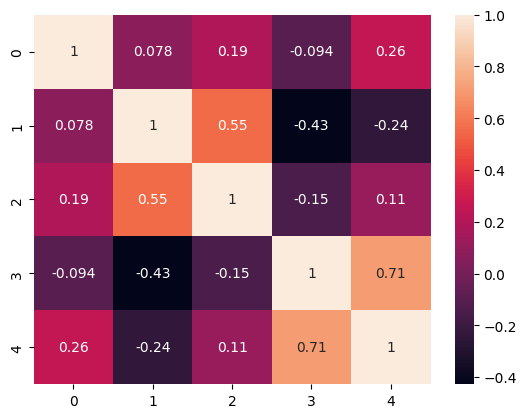

In [4]:
corr = pd.DataFrame(np.random.rand(10, 5)).corr()
sns.heatmap(corr, annot=True)

In [1]:
import unicodedata

emoji = "😃"
code_point = ord(emoji)  # Get the Unicode code point

print(f"The Unicode code point for '{emoji}' is: {code_point}")

# Convert the code point to hexadecimal
hex_code = hex(code_point)
print(f"The hexadecimal representation is: {hex_code}")

The Unicode code point for '😃' is: 128515
The hexadecimal representation is: 0x1f603


In [3]:
# Define the character
char = '😃'

# Get the Unicode code point
code_point = ord(char)

# Convert the code point to a hexadecimal string
hex_representation = f"{code_point:04x}"

print(f"The hexadecimal representation of '{char}' is: 0x{hex_representation}")

The hexadecimal representation of '😃' is: 0x1f603


In [5]:
"@elonmusk This is an example of https://fr.overleaf.com"

'@elonmusk This is an example of https://fr.overleaf.com'